In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
plt.style.use('seaborn')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'SimHei'
%matplotlib inline 

plt.rcParams['xtick.direction'] = 'inout'  # x軸刻度 位置
plt.rcParams['xtick.major.size'] = 3.5 # x軸刻度 長度

In [91]:
### 資料內容    　　　  chat: 縣市、區、速限(非道路)  　　　其他都是數字
#臺中市政府警察局106年11月份交通事故資料
url_10611 = 'https://quality.data.gov.tw/dq_download_csv.php?nid=72293&md5_url=27099e7b514bec2a041fd8d0194fbd69'

#臺中市政府警察局106年10月份交通事故資料
url_10610 = 'https://quality.data.gov.tw/dq_download_csv.php?nid=59792&md5_url=351eb4516b664646e487f4b7ff5d6671'

In [3]:
# 使用pandas讀取網路連結檔案
df_10611 = pd.read_csv(url_10611)
df_10610 = pd.read_csv(url_10610)

# 使用pandas 存檔
#df_10611.to_csv('交通事故10611.csv')
#df_10610.to_csv('交通事故10610.csv')

In [ ]:
## from datafram to sql : let nan to NULL into sql
## df = df.fillna(value='NULL')

## 'NULL' to nan
## df = df.replace('NULL', np.nan)

# def

In [4]:
## sql query for create table, df:dataframe, tablename:you want set tablename should be str
def create_table(df, tablename):
    q_create = 'create table ' + tablename + '('
    for i, j in zip(df.columns, df.dtypes):
        if j.name.find("int")==0:
            q_create = (q_create + '\n{} int NULL, ').format(i)
        elif j.name.find("float")==0:
            q_create = (q_create + '\n{} float NULL, ').format(i)
        else:
            q_create = (q_create + '\n{} varchar(20) NULL, ').format(i)
            
    q_create = q_create[:-2] + ');'   ##去掉最後的 逗點
    return(q_create)

In [40]:
## executemany版 sql語法###  insert into tablename values(?,)  ##########
## cursor.executemany(sql, df.values.tolist())
def sql_insert(df, tablename):
    sql_head = "insert into " + tablename + " values("
    sql_values = df.shape[1] * "%s, "
    sql_insert = sql_head + sql_values[:-2] + ")"
    return (str(sql_insert))

## 連接資料庫

In [6]:
# 資料庫連接  CHARSET=UTF8;
import pyodbc
cn = pyodbc.connect("DRIVER={MySQL ODBC 8.0 Unicode Driver}; SERVER=localhost; PORT=3306;DATABASE=taichung; UID=root; PASSWORD=******;OPTION=3;CHARSET=UTF8;") 
cursor = cn.cursor()

In [7]:
#cursor.execute("create database taichung;")
cursor.execute("use taichung;")
cursor.execute("show tables;")
print(cursor.fetchall())
#cursor.commit()
#cn.close()

[('tc_lite', )]


# Data Clearing

In [33]:
df10611 = df_10611.rename(columns={'2-30':'2_30', '當事者區分(類別)':'當事者區分_類別'})  #mysql 無法
df10611 = df10611.replace('  ', np.nan)
for i in range(len(df10611.columns)):
    df10611.iloc[:, i] = pd.to_numeric(df10611.iloc[:, i], errors='ignore')
df10611 = df10611.fillna(value='NULL')  # np.nan轉換後才能進資料庫
df10611.tail(3)

,年,月,日,時,分,縣市,區,死,受傷,2_30,...,車輛撞擊部位最初,車輛撞擊部位其他,肇事因素個別,肇事因素主要,肇事逃逸,職業,旅次目的,車種,GPS座標X,GPS座標Y
10129,2017,11,30,23,0,臺中市,豐原區,0,1,0,...,4,NULL,19,19,1,9,8,B12,24.2472,120.73
10130,2017,11,30,23,28,臺中市,西區,0,1,0,...,14,NULL,23,23,1,21,8,C03,24.1392,120.678
10131,2017,11,30,23,42,臺中市,南屯區,0,1,0,...,14,NULL,23,23,1,5,8,C03,24.139,120.61


In [68]:
df10610 = df_10610.rename(columns={'2-30':'2_30', '當事者區分(類別)':'當事者區分_類別'})
df10610 = df10610.replace('  ', np.nan)
for i in range(len(df10610.columns)):
    df10610.iloc[:, i] = pd.to_numeric(df10610.iloc[:, i], errors='ignore')
df10610 = df10610.fillna(value='NULL')  # np.nan轉換後才能進資料庫
df10610.tail(3)

,年,月,日,時,分,縣市,區,死,受傷,2_30,...,車輛撞擊部位最初,車輛撞擊部位其他,肇事因素個別,肇事因素主要,肇事逃逸,職業,旅次目的,車種,GPS座標X,GPS座標Y
10036,2017,10,31,23,9,臺中市,豐原區,NULL,NULL,NULL,...,NULL,NULL,NULL,NULL,1,NULL,NULL,C03,24.254,120.708
10037,2017,10,31,23,20,臺中市,北屯區,NULL,NULL,NULL,...,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL
10038,2017,10,31,23,25,臺中市,南屯區,0,1,0,...,5,NULL,23,23,1,22,8,B03,24.1452,120.623


# create table df_10611>tc10611, df_10610>tc10610

In [34]:
create_table(df10611, "tc_10611")

'create table tc_10611(\n年 int NULL, \n月 int NULL, \n日 int NULL, \n時 int NULL, \n分 int NULL, \n縣市 varchar(20) NULL, \n區 varchar(20) NULL, \n死 varchar(20) NULL, \n受傷 varchar(20) NULL, \n2_30 varchar(20) NULL, \n天候 varchar(20) NULL, \n光線 varchar(20) NULL, \n道路類別 varchar(20) NULL, \n速限 varchar(20) NULL, \n道路型態 varchar(20) NULL, \n事故位置 varchar(20) NULL, \n路面鋪裝 varchar(20) NULL, \n路面狀態 varchar(20) NULL, \n路面缺陷 varchar(20) NULL, \n障礙物 varchar(20) NULL, \n視距 varchar(20) NULL, \n號誌種類 varchar(20) NULL, \n號誌動作 varchar(20) NULL, \n分向設施 varchar(20) NULL, \n快車道或一般車道間 varchar(20) NULL, \n快慢車道間 varchar(20) NULL, \n路面邊線 varchar(20) NULL, \n事故類型及型態 varchar(20) NULL, \n主要肇因 varchar(20) NULL, \n受傷程度 varchar(20) NULL, \n主要傷處 varchar(20) NULL, \n保護裝備 varchar(20) NULL, \n行動電話 varchar(20) NULL, \n當事者區分_類別 varchar(20) NULL, \n車輛用途 varchar(20) NULL, \n當事者行動狀態 varchar(20) NULL, \n駕駛資格情形 varchar(20) NULL, \n駕駛執照種類 varchar(20) NULL, \n飲酒情形 varchar(20) NULL, \n車輛撞擊部位最初 varchar(20) NULL, \n車輛撞擊部位其他 varchar(20) NULL

In [11]:
cursor.execute(create_table(df10611, "tc_10611"))
cursor.execute(create_table(df10610, "tc_10610"))
cursor.execute("show tables;")
cursor.fetchall()

[('tc_10610', ), ('tc_10611', ), ('tc_lite', )]

# insert values

In [49]:
###### execute for loop####### df10611
tS = time.clock()
for i in df10611.index:
    cursor.execute("insert into tc_10611 values({})".format(str(df10611.loc[i].values.tolist())[1:-1]))
#cn.commit()
tE = time.clock()
print("insert %s筆資料用時:"%df10611.shape[0], tE-tS, "seconds")

insert 10132筆資料用時: 18.523254162308262 seconds


In [65]:
cursor.execute("select * from tc_10611 limit 3")
cursor.fetchall()

[(2017, 11, 1, 0, 7, '臺中市', '霧峰區', '0.0', '0.0', '0.0', '8.0', '3.0', '5.0', '40', '14.0', '2.0', '1.0', '5.0', '4.0', '5.0', '7.0', '4.0', '4.0', '1.0', '4.0', '4.0', '1.0', '26.0', '21.0', '3.0', '10.0', '1.0', '1.0', 'B03', '7.0', '9.0', '1.0', '8.0', '7.0', '8.0', 'NULL', '21.0', '21.0', '1.0', '4.0', '8.0', 'B03', '24.073801', '120.663218'),
 (2017, 11, 1, 0, 17, '臺中市', '潭子區', 'NULL', 'NULL', 'NULL', '8.0', 'NULL', 'NULL', '60', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'B03', 'NULL', 'NULL', '1.0', 'NULL', '1.0', 'NULL', 'NULL', '13.0', 'NULL', '1.0', '22.0', 'NULL', 'B03', '24.201317', '120.70316299999999'),
 (2017, 11, 1, 1, 0, '臺中市', '潭子區', '0.0', '1.0', '0.0', '8.0', '3.0', '5.0', '50', '4.0', '1.0', '1.0', '5.0', '4.0', '5.0', '7.0', '3.0', '1.0', '10.0', '5.0', '5.0', '2.0', '15.0', '6.0', '2.0', '9.0', '1.0', '1.0', 'C03', '7.0', '9.0', '1.0', '10.0', '2.0', '11.0'

In [73]:
###### execute for loop####### df10610
tS = time.clock()
for i in df10610.index:
    cursor.execute("insert into tc_10610 values({})".format(str(df10610.loc[i].values.tolist())[1:-1]))
    #cn.commit()
tE = time.clock()
print("insert %s筆資料用時:"%df10610.shape[0], tE-tS, "seconds")

insert 10039筆資料用時: 17.7935123165571 seconds


###### executemany #######
tS = time.clock()
cursor.executemany(sql_insert(df10610, "tc_10610"), df10610.values.tolist())
tE = time.clock()
print("insert %s筆資料用時:"%df10610.shape[0], end-start, "seconds")

# select columns form table to python dataframe

In [78]:
#df10611f = pd.read_sql("select 年, 月, 日, 時, 分, 縣市, 區, GPS座標X, GPS座標Y from tc_10611;", con = cn)
print(df10611f.info())
df10611f.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10132 entries, 0 to 10131
Data columns (total 9 columns):
年         10132 non-null int64
月         10132 non-null int64
日         10132 non-null int64
時         10132 non-null int64
分         10132 non-null int64
縣市        10132 non-null object
區         10132 non-null object
GPS座標X    10132 non-null object
GPS座標Y    10132 non-null object
dtypes: int64(5), object(4)
memory usage: 712.5+ KB
None


,年,月,日,時,分,縣市,區,GPS座標X,GPS座標Y
0,2017,11,1,0,7,臺中市,霧峰區,24.073801,120.663218
1,2017,11,1,0,17,臺中市,潭子區,24.201317,120.70316299999999
2,2017,11,1,1,0,臺中市,潭子區,24.19456,120.701118


In [80]:
df10610f = pd.read_sql("select 年, 月, 日, 時, 分, 縣市, 區, GPS座標X, GPS座標Y from tc_10610;", con = cn)
print(df10610f.info())
df10610f.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10040 entries, 0 to 10039
Data columns (total 9 columns):
年         10040 non-null int64
月         10040 non-null int64
日         10040 non-null int64
時         10040 non-null int64
分         10040 non-null int64
縣市        10040 non-null object
區         10040 non-null object
GPS座標X    10040 non-null object
GPS座標Y    10040 non-null object
dtypes: int64(5), object(4)
memory usage: 706.0+ KB
None


,年,月,日,時,分,縣市,區,GPS座標X,GPS座標Y
0,2017,10,1,0,1,臺中市,南屯區,24.132123999999997,120.64829099999999
1,2017,10,1,0,1,臺中市,南屯區,24.132123999999997,120.64829099999999
2,2017,10,1,0,5,臺中市,南屯區,24.135295000000003,120.638802


In [81]:
df = pd.concat([df10610f, df10611f])

# Data Clearing  #select from MySQL

In [82]:
# return "NULL" to nan
df = df.replace('NULL', np.nan)
#set colums to muneric if not str
for i in range(len(df.columns)):
    df.iloc[:, i] = pd.to_numeric(df.iloc[:, i], errors='ignore')
df.loc[:,'count'] = 1
df_month = pd.get_dummies(df['月'])
df = df.join(df_month)
df = df.rename(columns={10:'10月', 11:'11月'})

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40252 entries, 0 to 10131
Data columns (total 12 columns):
年         40252 non-null int64
月         40252 non-null int64
日         40252 non-null int64
時         40252 non-null int64
分         40252 non-null int64
縣市        40252 non-null object
區         40252 non-null object
GPS座標X    38185 non-null float64
GPS座標Y    38185 non-null float64
count     40252 non-null int64
10月       40252 non-null uint8
11月       40252 non-null uint8
dtypes: float64(2), int64(6), object(2), uint8(2)
memory usage: 3.5+ MB


# create charts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

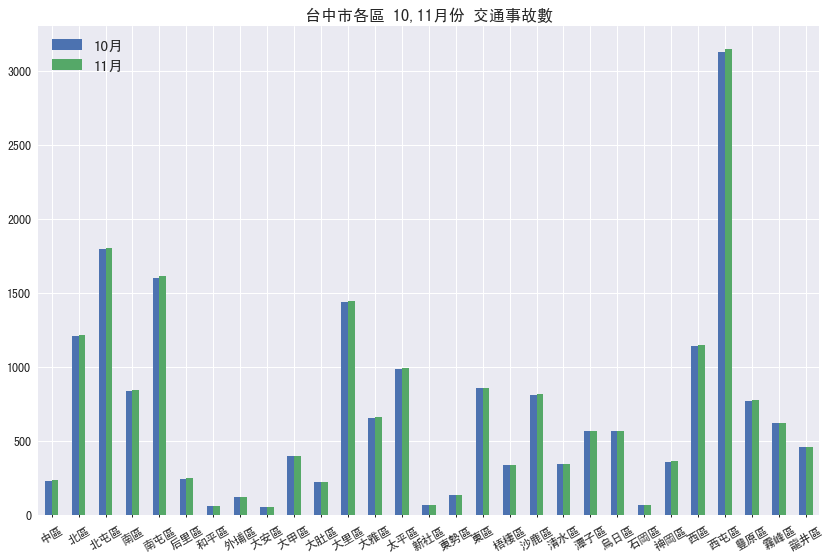

In [88]:
# 10月&11月交通事故數量比較
c = df.groupby(['區'])['10月','11月'].sum()
c.plot(kind = 'bar', figsize=(14,9), align='center', fontsize=12)
plt.title("台中市各區 10,11月份 交通事故數", fontsize=16)
plt.xlabel("")
plt.legend(fontsize = 15)
plt.xticks(rotation=30)

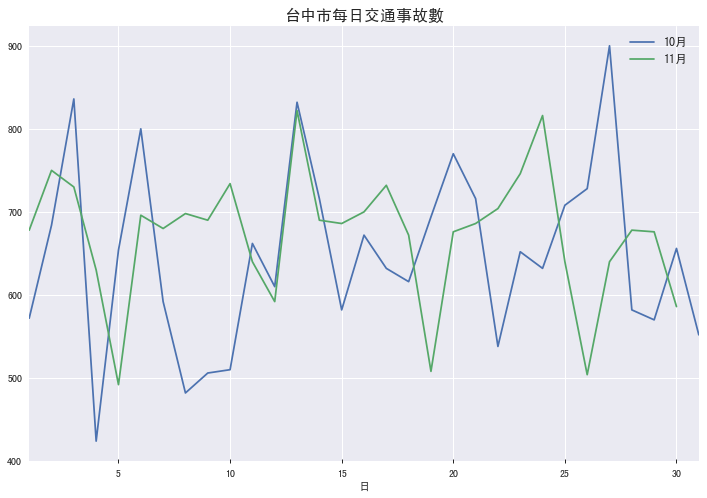

In [89]:
# 10,11月份 每日交通事故比較
df10 = df[df['月']==10].groupby(['日'])['count'].sum()
df11 = df[df['月']==11].groupby(['日'])['count'].sum()
df10.plot(kind = 'line', figsize=(12,8), label='10月', legend=True)
df11.plot(kind = 'line', label='11月', legend=True)
plt.legend(fontsize = 12)
plt.title("台中市每日交通事故數", fontsize = 16)

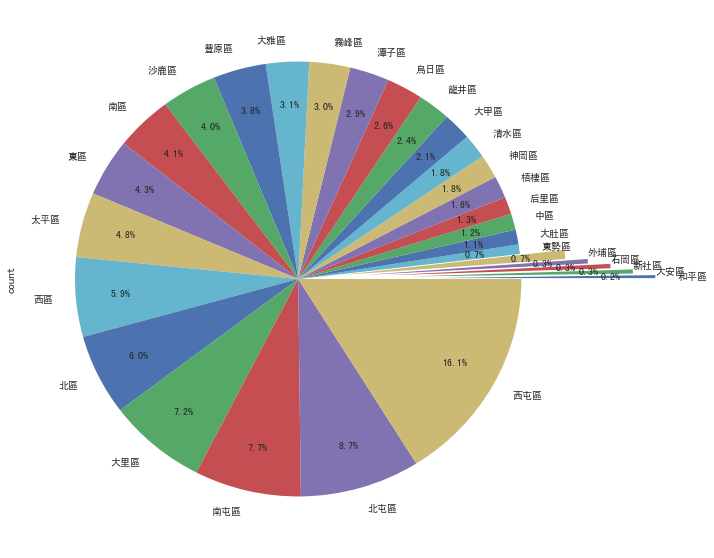

In [90]:
df_pie = df[df['月']==10].groupby(['區'])['count'].sum()
df_pie = df_pie.sort_values()
explode = (0.6, 0.5, 0.4, 0.3, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
df_pie.plot(kind = 'pie', explode = explode, figsize=(10, 10), autopct='%1.1f%%', pctdistance=0.8, labeldistance=1.1)

# ===========================================

## =========== create table 進化史 ===========

In [ ]:
######## def create table ######## 
## df:dataframe, tablename:you want set tablename should be str
def create_table(df, tablename):
    q_create = 'create table ' + tablename + '('
    for i, j in zip(df.columns, df.dtypes):
        if j.name.find("int")==0:
            q_create = (q_create + '\n{} int NULL, ').format(i)
        elif j.name.find("float")==0:
            q_create = (q_create + '\n{} float NULL, ').format(i)
        else:
            q_create = (q_create + '\n{} varchar(20) NULL, ').format(i)
            
    q_create = q_create[:-2] + ');'   ##去掉最後的 逗點
    return(q_create)

In [534]:
######### create table 3版 #########看第一列決定type
q_tc = 'create table tc_lite('

for k in range(1):
    for i, j in zip(dff.columns, dff.dtypes):
        if type(dff.loc[0][i]) == str:
            q_tc = (q_tc + '\n{} varchar(20) NULL,').format(i)
        elif type(dff.loc[0][i]) == float:
            q_tc = (q_tc + '\n{} float NULL,').format(i)
        else:
            q_tc = (q_tc + '\n{} int NULL,').format(i)
            
q_tc = q_tc[:-1] + ');'   ##去掉最後的 逗點
print(q_tc)

create table tc_lite(
年 int NULL,
月 int NULL,
日 int NULL,
時 int NULL,
分 int NULL,
縣市 varchar(20) NULL,
區 varchar(20) NULL,
GPS座標X float NULL,
GPS座標Y float NULL);


In [ ]:
######### create table 1版 #########
query = 'create table newtable('

for k in range(1):
    for i, j in zip(df1.columns, df1.dtypes):
        if j.name.find("int")==0:
            query = (query + '\n{} int NULL,').format(i)
        elif j.name.find("float")==0:
            query = (query + '\n{} float NULL,').format(i)
        else:
            query = (query + '\n{} varchar(20) NULL,').format(i)
            
query = query[:-1] + ');'   ##去掉最後的 逗點
print(query)

## =========== insert into table 進化史 ===========

### cursor.execute() with for loop

In [ ]:
######### insert 4版 #########
for i in df.index:
    cursor.execute("insert into tc_lite values({})".format(str(list(df.loc[i]))[1:-1]))
cursor.execute("select * from tc_lite;")
cursor.fetchall()

In [105]:
######### insert 3版 #########
for i in df.index:
    cursor.execute("insert into tc_lite values({}, {}, {}, {}, {}, '{}', '{}', {}, {});" \
          .format(df.loc[i][0], df.loc[i][1], df.loc[i][2], df.loc[i][3], df.loc[i][4], df.loc[i][5], df.loc[i][6]\
                 , df.loc[i][7], df.loc[i][8]))
cursor.commit()

In [ ]:
######### insert 2版 #########
i = 0
for i in df.index:
    cursor.execute("insert into qtable values({}, {});" .format(df.loc[i]['年'], df.loc[i]['月']))
    i +=1

In [ ]:
######### insert 1版 #########
i = 0
for i in df.index:
    cursor.execute("insert into new values(%d, %d);" %(df['年'][i:i+1], df['月'][i:i+1]))
    i +=1

### cursor.executemany(sql, df.values.tolist()))

In [ ]:
######## def insert into table values() ########  cursor.executemany
## cursor.executemany(sql, df.values.tolist())
def sql_insert(df, tablename):
    sql_head = "insert into " + tablename + " values("
    sql_values = df.shape[1] * "%s, "
    sql_insert = sql_head + sql_values[:-2] + ")"
    return (str(sql_insert))

In [ ]:
## executemany 一版  insert into語法
sqli = "insert into exmany values("
sqlv = manydf.shape[1]*'?, ' 
sql_create = sqli + sqlv[:-2]+")"
sql_create

# ======== 測試區 ========